In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName('Titanic Data') \
    .getOrCreate()

In [31]:
spark

In [32]:
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("conflicts.csv"))

In [33]:
df.show(3)

+---+---+----------+----------+--------------------+--------------------+-------------+--------------------+-------------+-----------+---------------+-------+---------+------------+-----------+-----------------+--------------------+----------+
|_c0|ISO|EVENT_DATE|EVENT_TYPE|      SUB_EVENT_TYPE|              ACTOR1|ASSOC_ACTOR_1|              ACTOR2|ASSOC_ACTOR_2|INTERACTION|         REGION|COUNTRY|   ADMIN1|      ADMIN2|   LOCATION|           SOURCE|               NOTES|FATALITIES|
+---+---+----------+----------+--------------------+--------------------+-------------+--------------------+-------------+-----------+---------------+-------+---------+------------+-----------+-----------------+--------------------+----------+
|  0| 12|2010-12-20|   Battles|         Armed clash|Military Forces o...|         null|Unidentified Arme...|         null|         13|Northern Africa|Algeria|Boumerdes|       Ammal|Ait Dahmane|      TSA Algerie|A militant was ca...|         0|
|  1| 12|2010-12-25|    

In [34]:
df.dtypes

[('_c0', 'string'),
 ('ISO', 'string'),
 ('EVENT_DATE', 'string'),
 ('EVENT_TYPE', 'string'),
 ('SUB_EVENT_TYPE', 'string'),
 ('ACTOR1', 'string'),
 ('ASSOC_ACTOR_1', 'string'),
 ('ACTOR2', 'string'),
 ('ASSOC_ACTOR_2', 'string'),
 ('INTERACTION', 'string'),
 ('REGION', 'string'),
 ('COUNTRY', 'string'),
 ('ADMIN1', 'string'),
 ('ADMIN2', 'string'),
 ('LOCATION', 'string'),
 ('SOURCE', 'string'),
 ('NOTES', 'string'),
 ('FATALITIES', 'string')]

In [35]:
df.describe().toPandas()

,summary,_c0,ISO,EVENT_DATE,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,ACTOR2,ASSOC_ACTOR_2,INTERACTION,REGION,COUNTRY,ADMIN1,ADMIN2,LOCATION,SOURCE,NOTES,FATALITIES
0,count,170578,170578,170578,170578,170578,170578,44078,120235,31630,170578,170578,170578,170578,170497,170578,170578,170569,170578
1,mean,85288.5,524.649925547257,None,None,None,None,None,None,None,34.586605541160054,None,None,None,None,None,None,None,1.7503019146666041
2,stddev,49241.77144626975,251.68053502042525,None,None,None,None,None,None,None,19.07524097084693,None,None,None,None,None,None,None,9.874958100076823
3,min,0,108,2010-12-18,Battles,Abduction/forced disappearance,101 Battalion (Tajoura),#1980FMZ: Freedom Movement Zimbabwe,3rd Brigade,#EndSARS,10,Eastern Africa,Algeria,Abia,10 Ramadan 1,1 de Maio,1847 Post,250 child soldiers recruited by the South Sud...,0
4,max,99999,894,2020-10-24,Violence against civilians,Violent demonstration,Zwai Ethnic Militia (Libya),the Moroccan Organization to support the Affai...,Zwai Ethnic Militia (Libya),Zwai Ethnic Militia (Libya),88,Western Africa,eSwatini,Zou,uThungulu,uMhlanga Rocks,iHarare,~800 Mai Mai militia members (possibly led by ...,99


In [36]:
dataset = df.select(col('FATALITIES').cast('float'),
                         col('INTERACTION').cast('float'),
                         col('COUNTRY'),
                         col('REGION'),
                         col('ACTOR1'),
                         col('ACTOR2'),
                         col('EVENT_TYPE'),
                        )

In [37]:
dataset.show(1)

+----------+-----------+-------+---------------+--------------------+--------------------+----------+
|FATALITIES|INTERACTION|COUNTRY|         REGION|              ACTOR1|              ACTOR2|EVENT_TYPE|
+----------+-----------+-------+---------------+--------------------+--------------------+----------+
|       0.0|       13.0|Algeria|Northern Africa|Military Forces o...|Unidentified Arme...|   Battles|
+----------+-----------+-------+---------------+--------------------+--------------------+----------+
only showing top 1 row



In [38]:
dataset.select([count(when(isnull(c), c)).alias(c) for c in dataset.columns]).show()

+----------+-----------+-------+------+------+------+----------+
|FATALITIES|INTERACTION|COUNTRY|REGION|ACTOR1|ACTOR2|EVENT_TYPE|
+----------+-----------+-------+------+------+------+----------+
|         0|          0|      0|     0|     0| 50343|         0|
+----------+-----------+-------+------+------+------+----------+



In [39]:
dataset = dataset.replace('?', None)\
        .dropna(how='any')

In [40]:
from pyspark.ml.feature import StringIndexer
dataset = StringIndexer(
    inputCol='INTERACTION', 
    outputCol='INTERNO', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset = StringIndexer(
    inputCol='COUNTRY', 
    outputCol='COUNTNO', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset = StringIndexer(
    inputCol='REGION', 
    outputCol='REGNO', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset = StringIndexer(
    inputCol='ACTOR1', 
    outputCol='ACT1', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset = StringIndexer(
    inputCol='ACTOR2', 
    outputCol='ACT2', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset = StringIndexer(
    inputCol='EVENT_TYPE', 
    outputCol='EVENTNO', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset.show(2)

+----------+-----------+-------+---------------+--------------------+--------------------+----------+-------+-------+-----+-----+-----+-------+
|FATALITIES|INTERACTION|COUNTRY|         REGION|              ACTOR1|              ACTOR2|EVENT_TYPE|INTERNO|COUNTNO|REGNO| ACT1| ACT2|EVENTNO|
+----------+-----------+-------+---------------+--------------------+--------------------+----------+-------+-------+-----+-----+-----+-------+
|       0.0|       13.0|Algeria|Northern Africa|Military Forces o...|Unidentified Arme...|   Battles|    2.0|   18.0|  1.0| 60.0| 69.0|    0.0|
|       0.0|       15.0|Algeria|Northern Africa|Police Forces of ...|   Rioters (Algeria)|     Riots|    5.0|   18.0|  1.0|159.0|139.0|    2.0|
+----------+-----------+-------+---------------+--------------------+--------------------+----------+-------+-------+-----+-----+-----+-------+
only showing top 2 rows



In [66]:
# Drop unnecessary columns
dataset = dataset.drop('COUNTRY')
dataset = dataset.drop('INTERACTION')
dataset = dataset.drop('REGION')
dataset = dataset.drop('ACTOR1')
dataset = dataset.drop('ACTOR2')
dataset = dataset.drop('EVENT_TYPE')
dataset = dataset.drop('LOCATION')
dataset = dataset.drop('SOURCE')
dataset = dataset.drop('COUNTNO')
dataset = dataset.drop('FATALITIES')
dataset.show()

+-------+-----+-----+-----+-------+
|INTERNO|REGNO| ACT1| ACT2|EVENTNO|
+-------+-----+-----+-----+-------+
|    2.0|  1.0| 60.0| 69.0|    0.0|
|    5.0|  1.0|159.0|139.0|    2.0|
|    1.0|  1.0|141.0| 97.0|    0.0|
|    5.0|  1.0|159.0|139.0|    2.0|
|    5.0|  1.0|159.0|139.0|    2.0|
|    5.0|  1.0| 82.0| 60.0|    2.0|
|    5.0|  1.0|159.0|139.0|    2.0|
|    2.0|  1.0|134.0| 97.0|    0.0|
|    5.0|  1.0| 82.0| 60.0|    2.0|
|    2.0|  1.0|134.0| 97.0|    0.0|
|    8.0|  1.0| 82.0| 99.0|    2.0|
|    5.0|  1.0| 82.0| 60.0|    2.0|
|    5.0|  1.0|159.0|139.0|    2.0|
|    5.0|  1.0| 82.0| 60.0|    2.0|
|    5.0|  1.0| 82.0| 60.0|    2.0|
|    5.0|  1.0| 82.0| 60.0|    2.0|
|    5.0|  1.0|159.0|139.0|    2.0|
|    5.0|  1.0|159.0|139.0|    2.0|
|    5.0|  1.0| 82.0| 60.0|    2.0|
|    5.0|  1.0| 82.0| 60.0|    2.0|
+-------+-----+-----+-----+-------+
only showing top 20 rows



In [67]:
# Assemble all the features with VectorAssembler
required_features = ['INTERNO',
                    'REGNO',
                    'ACT1',
                     'ACT2',
                   ]
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=required_features,
outputCol='features')
transformed_data = assembler.transform(dataset)

In [68]:
transformed_data.show()

+-------+-----+-----+-----+-------+--------------------+
|INTERNO|REGNO| ACT1| ACT2|EVENTNO|            features|
+-------+-----+-----+-----+-------+--------------------+
|    2.0|  1.0| 60.0| 69.0|    0.0| [2.0,1.0,60.0,69.0]|
|    5.0|  1.0|159.0|139.0|    2.0|[5.0,1.0,159.0,13...|
|    1.0|  1.0|141.0| 97.0|    0.0|[1.0,1.0,141.0,97.0]|
|    5.0|  1.0|159.0|139.0|    2.0|[5.0,1.0,159.0,13...|
|    5.0|  1.0|159.0|139.0|    2.0|[5.0,1.0,159.0,13...|
|    5.0|  1.0| 82.0| 60.0|    2.0| [5.0,1.0,82.0,60.0]|
|    5.0|  1.0|159.0|139.0|    2.0|[5.0,1.0,159.0,13...|
|    2.0|  1.0|134.0| 97.0|    0.0|[2.0,1.0,134.0,97.0]|
|    5.0|  1.0| 82.0| 60.0|    2.0| [5.0,1.0,82.0,60.0]|
|    2.0|  1.0|134.0| 97.0|    0.0|[2.0,1.0,134.0,97.0]|
|    8.0|  1.0| 82.0| 99.0|    2.0| [8.0,1.0,82.0,99.0]|
|    5.0|  1.0| 82.0| 60.0|    2.0| [5.0,1.0,82.0,60.0]|
|    5.0|  1.0|159.0|139.0|    2.0|[5.0,1.0,159.0,13...|
|    5.0|  1.0| 82.0| 60.0|    2.0| [5.0,1.0,82.0,60.0]|
|    5.0|  1.0| 82.0| 60.0|    

In [69]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

In [70]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol='EVENTNO', 
                            featuresCol='features',
                            maxBins=3589,
                            maxDepth=5)

In [71]:
model = rf.fit(training_data)

In [72]:
predictions = model.transform(test_data)

In [75]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol='EVENTNO', 
    predictionCol='prediction', 
    metricName='accuracy')

In [76]:
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.8135628456197248


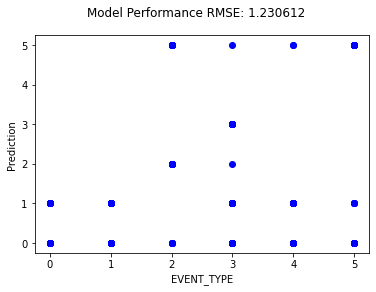

In [78]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="EVENTNO", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rfPred = model.transform(transformed_data)
rfResult = rfPred.toPandas()
plt.plot(rfResult.EVENTNO, rfResult.prediction, 'bo')
plt.xlabel('EVENT_TYPE')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()